This Project aims to predict whether the patient will show up in his medical appointement or not.
For that, two machine learning approaches where used:
1.   Random Forest
2.   Neural networks

In order to choose the best approache, The models were evaluated based on their accuracy.





In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Test/Test1/ 

/content/gdrive/MyDrive/Test/Test1


In [3]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, accuracy_score, recall_score, precision_recall_curve, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
from torch import Tensor
import torch.nn.functional as F
import os
from tqdm import tqdm

In [4]:
#Import Data
data = pd.read_csv('medical_appointment_train.csv')
data.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


There were 5 main cleaning steps: 
1.   Dropping observations that had logical inconsistencies, such as negative ages.
2.   Considering only the last visit for patients that have made several visits.
3.   Splitting scheduledDay and AppointementDay into day, month,year and hour columns.
4.   Dropping Useless columns.
5.   Dara encoding: Binary coding (1,0) no-shows, gender and categorical encoding for the Neighbourhood.



In [5]:
#Data Cleaning

#Check Age
print(sorted(data['Age'].unique()))
#Remove Age <0
data = data[data.Age >= 0]

#Transfom patient ID into integer and sort it
data['PatientID'] = data['PatientID'].astype('int64')
data.sort_values(by=['PatientID']) 

# Convert ScheduledDay and AppointmentDay to datetime64[ns]
data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay']).dt.date.astype('datetime64[ns]')
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay']).dt.date.astype('datetime64[ns]')

data.info()

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PatientID       110526 non-null  int64         
 1   AppointmentID   110526 non-null  int64         
 2   Gender          110526 non-null  object        
 3   ScheduledDay    110526 non-null  datetime64[ns]
 4   AppointmentDay  110526 non-null  datetime64[ns]
 5   Age             110526 non-null  int64         
 6   Neighbourhood   110526 non-null  object        
 7

In [6]:
#Consider only last visit for patient with several records (Several scheduledDay with same PatientID)
prev=-1
l=[]
for i,id in enumerate(data['PatientID']):
  if id==prev:
    if data['ScheduledDay'][i]>data['ScheduledDay'][i-1]:
      l.append(i-1)
    else:
      l.append(i) 
  prev=id
data.drop(l,inplace=True)
data

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293,5651768,F,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3596266328735,5650093,F,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,15576631729893,5630692,F,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,92134931435557,5630323,F,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [7]:
#Split dates into month,day,hour,year
#Scheduled date
data['Scheduledyear'] = data['ScheduledDay'].dt.year
data['ScheduledMonth'] = data['ScheduledDay'].dt.month
data['ScheduledDayofWeek'] = data['ScheduledDay'].dt.weekday
data['ScheduledHour'] = data['ScheduledDay'].dt.hour
#drop useless columns
data = data.drop(['AppointmentDay','ScheduledDay'],axis=1)
data

,PatientID,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,Scheduledyear,ScheduledMonth,ScheduledDayofWeek,ScheduledHour
0,29872499824296,5642903,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016,4,4,0
1,558997776694438,5642503,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016,4,4,0
2,4262962299951,5642549,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016,4,4,0
3,867951213174,5642828,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016,4,4,0
4,8841186448183,5642494,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016,4,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293,5651768,F,56,MARIA ORTIZ,0,0,0,0,0,1,No,2016,5,1,0
110523,3596266328735,5650093,F,51,MARIA ORTIZ,0,0,0,0,0,1,No,2016,5,1,0
110524,15576631729893,5630692,F,21,MARIA ORTIZ,0,0,0,0,0,1,No,2016,4,2,0
110525,92134931435557,5630323,F,38,MARIA ORTIZ,0,0,0,0,0,1,No,2016,4,2,0


In [8]:
def Boolen(x):
    
    if x == 'F':
        return 0
    elif x == 'No':
        return 0
    elif x == 'Yes':
        return 1
    elif x == 'M':
        return 1
        
binary = ['Gender', 'No-show'] 
for cols in binary:
    data[cols] = data[cols].apply(Boolen)

#Encode Neighbourhood
le = LabelEncoder().fit(data['Neighbourhood'])
data['Neighbourhood']=le.transform(data['Neighbourhood'])

Now that the data is cleaned, we need to split it into training set and test set.

In [9]:
#Split Test Train
X, y = data.drop(['No-show'],axis=1), data['No-show'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
X_train,X_test,y_train,y_test = np.array(X_train), np.array(X_test), np.array(y_train) ,np.array(y_test)
X_train.shape,y_train.shape

((86264, 15), (86264,))

In [16]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test=scaler.transform(X_test)

After spliting and scaling the data,The training set were used to train the first model: Random forest.



In [10]:
#Model 1 : Random Forest Classifier
dtree = RandomForestClassifier(n_estimators=100,verbose=1)
history=dtree.fit(scaled_X_train, y_train)
y_predict = dtree.predict(scaled_X_test)
print("Accuracy:  ",accuracy_score(y_test, y_predict))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy:   0.7959846061111884


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


For the second Model,we used a pytorch implementation. The key idea of our network is to transform tabular data into an image and feed it to a CNN.

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
num_epochs = 5
batch_size = 50
lr = 0.001 
NUM_CLASSES = 2

In [12]:
class ClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        labels = labels.squeeze_()
        labels = labels.type(torch.LongTensor)
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        labels = labels.squeeze_()
        labels = labels.type(torch.LongTensor)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch, result['train_loss'], result['test_loss'], result['test_acc']))

The network is composed of fully connected layers that transform the input into a highier dimension (15 to 1024). the output of the fully connected layers will be reshaped into a 128 by 16 images. After reshaping, we stack conv layers with 16, 32 and 64 output channels.And finally, the output of the final conv layer will go through a fully connected layers. 

In [13]:
class Classification(ClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            
            nn.Linear(15,1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Unflatten(1, (1, 64, 16)), # reshape tabular data into an image. We need to make sure that HEIGHT*WIDTH = Number of features of tabular data (1024 in this case)

            nn.Conv2d(1, 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64 ,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(4096,1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512,NUM_CLASSES)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader), smoothing=0.9, position=0, leave=True):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history   


In [17]:
train_data = TensorDataset( Tensor(scaled_X_train), Tensor(y_train))
test_data = TensorDataset( Tensor(scaled_X_test), Tensor(y_test) )
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(test_data, batch_size, num_workers = 2, pin_memory = True)
opt_func = torch.optim.Adam
model = Classification()

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

100%|██████████| 1726/1726 [06:59<00:00,  4.12it/s]


Epoch [0], train_loss: 0.4997, test_loss: 0.4886, test_acc: 0.7951


100%|██████████| 1726/1726 [06:52<00:00,  4.18it/s]


Epoch [1], train_loss: 0.4869, test_loss: 0.4912, test_acc: 0.7945


100%|██████████| 1726/1726 [06:47<00:00,  4.23it/s]


Epoch [2], train_loss: 0.4844, test_loss: 0.4819, test_acc: 0.7937


100%|██████████| 1726/1726 [06:53<00:00,  4.18it/s]


Epoch [3], train_loss: 0.4813, test_loss: 0.4853, test_acc: 0.7950


100%|██████████| 1726/1726 [06:52<00:00,  4.19it/s]


Epoch [4], train_loss: 0.4782, test_loss: 0.4905, test_acc: 0.7956


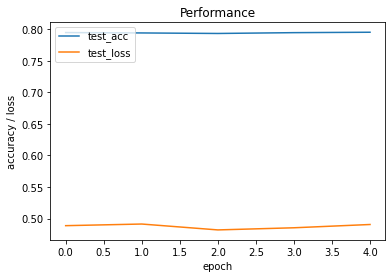

In [19]:
val_acc, val_loss = [],[]
for i in range(num_epochs):
  val_acc.append(history[i]['test_acc'])
  val_loss.append(history[i]['test_loss'])
plt.plot(val_acc)
plt.plot(val_loss)
plt.title('Performance')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['test_acc', 'test_loss'], loc='upper left')
plt.show()

The Random forest and the IGTD approaches presents similar results.
The IGTD performances can be improved by training it on more epochs and modifying its architecture by adding more layers.